In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import palettable

from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coords

import neighbors

In [3]:
!ls ../data/tess-gi/

ExampleAllocationRequest-Astrophysics
ExampleAllocationRequest-Astrophysics.zip
MAST_TIC_Proxima_Cen.csv
core-science-targets-v2.csv
oh17star_MAST_Crossmatch_CTL.csv
omega_cen_target_table.csv
star_groupsize2_radec.csv
star_groupsize2_radec.csv-tvguide.csv


# Cross-match with TESS CTL

Using mast portal; for all stars; radius=3 arcsec

In [4]:
candi = pd.read_csv("files/oh17star_MAST_Crossmatch_CTL.csv", comment='#')
print(len(candi))
print(', '.join(candi.columns))

8929
row_id, tgas_source_id, name, ra, dec, parallax, distance, G, J, rave_obs_id, rv, erv, group_id, group_size, MatchID, MatchRA, MatchDEC, pmRA, pmDEC, Tmag, objType, typeSrc, dstArcSec, version, HIP, TYC, UCAC, TWOMASS, SDSS, ALLWISE, GAIA, APASS, KIC, POSflag, e_pmRA, e_pmDEC, PMflag, plx, e_plx, PARflag, gallong, gallat, eclong, eclat, Bmag, e_Bmag, Vmag, e_Vmag, umag, e_umag, gmag, e_gmag, rmag, e_rmag, imag, e_imag, zmag, e_zmag, Jmag, e_Jmag, Hmag, e_Hmag, Kmag, e_Kmag, TWOMflag, prox, w1mag, e_w1mag, w2mag, e_w2mag, w3mag, e_w3mag, w4mag, e_w4mag, GAIAmag, e_GAIAmag, e_Tmag, TESSflag, SPFlag, Teff, e_Teff, logg, e_logg, MH, e_MH, rad, e_rad, mass, e_mass, rho, e_rho, lumclass, lum, e_lum, d, e_d, ebv, e_ebv, numcont, contratio, disposition, duplicate_i, priority, subPriority


Check duplicate rows with `row_id` (which is unique in the matching catalog)

In [5]:
candi.loc[candi.row_id.duplicated(keep=False)]\
    .sort_values('row_id')[['row_id','name','MatchID','HIP','TYC']]

,row_id,name,MatchID,HIP,TYC
8739,378,HIP 80290,392178089,80290,6802-01266-1
5192,378,HIP 80290,392178090,0,NaN
8786,861,TYC 1483-569-2,347436570,0,1483-00569-1
6407,861,TYC 1483-569-2,347436569,0,1483-00569-2
738,1327,HIP 59781,383337212,0,NaN
8620,1327,HIP 59781,383337214,59781,8978-05406-1
3620,2957,TYC 4065-1109-1,84894226,0,NaN
8282,2957,TYC 4065-1109-1,84894224,0,4065-01109-1
7755,2958,TYC 4065-1109-2,84894224,0,4065-01109-1
2402,2958,TYC 4065-1109-2,84894222,0,4065-01109-2


Let's not deal with duplicates. Remove them, and focus on pairs only.

In [30]:
candi = candi.loc[~candi.row_id.duplicated(keep=False)]

candi2 = candi.loc[candi.group_size==2]

Check how many pairs have both stars matched:

In [44]:
candi2.group_id.value_counts().value_counts()

2    3137
1     835
Name: group_id, dtype: int64

Check how many pairs with both stars matched have RAVE RVs for both stars:

In [53]:
pairdf = pd.DataFrame(candi2.group_id.value_counts(),)

In [74]:
rows = []
for g in pairdf.index:
    if (candi2.group_id==g).sum() == 2:
        rows.append(candi2.loc[candi2.group_id==g, ['row_id', 'rv', 'erv']].values.ravel()[None,:])
    else:
        rows.append([np.nan]*6)

In [75]:
rows = np.vstack(rows)

In [91]:
drv = rows[:,1]-rows[:,4]
edrv = np.hypot(rows[:,2], rows[:,5])

In [99]:
print("N pairs with RVs = ", (~np.isnan(drv)).sum(), "/", drv.size)

N pairs with RVs =  170 / 3972


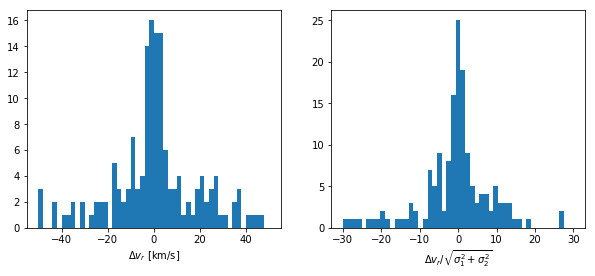

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(drv[~np.isnan(drv)], np.linspace(-50,50,51))
ax[0].set_xlabel('$\Delta v_r$ [km/s]')
ax[1].hist(drv[~np.isnan(drv)]/edrv[~np.isnan(drv)], np.linspace(-30,30,50));
ax[1].set_xlabel('$\Delta v_r / \sqrt{\sigma_1^2 + \sigma_2^2}$')

But then this is probably irrelevant for cycle 1..

# Cycle 1 Observability with tvguide


```sh
$tvguide-csv star_groupsize2_radec.csv
```

In [108]:
!head -n 3 ../data/tess-gi/star_groupsize2_radec.csv

ra,dec
22.484376,-48.351785
85.085926,37.745584


In [109]:
!head -n 3 ../data/tess-gi/star_groupsize2_radec.csv-tvguide.csv

       nan,        nan, 0, 0
22.4843760000, -48.3517850000, 0, 2
85.0859260000, 37.7455840000, 0, 0


In [183]:
!wc -l ../data/tess-gi/star_groupsize2_radec*

    8473 ../data/tess-gi/star_groupsize2_radec.csv
    8473 ../data/tess-gi/star_groupsize2_radec.csv-tvguide.csv
   16946 total


In [6]:
star, pair, group = neighbors.data.load_oh17()

In [7]:
tv = pd.read_csv("files/star_groupsize2_radec.csv-tvguide.csv",header=None,
                 names=['ra','dec','minsec','maxsec'], skiprows=1)

star2 = star.loc[star.group_size==2].copy()
canditv = pd.merge(star2, tv[['minsec','maxsec']], left_index=True, right_index=True)

In [8]:
canditv.minsec.value_counts()

0     6330
2      228
1       82
12      78
6       25
4       23
11      14
10       9
8        8
5        4
7        3
3        3
Name: minsec, dtype: int64

In [9]:
canditv.maxsec.value_counts()

0     3439
2     1856
1     1044
3      242
13      78
4       59
12      17
5       15
7       13
6       12
10      11
8        9
11       6
9        6
Name: maxsec, dtype: int64

Check
- maxsec > 0
- both has RAVE RV

In [10]:
canditv.loc[(canditv['maxsec']>0) & (~canditv['rv'].isnull())]\
      .group_id.value_counts().value_counts()

1    303
2     35
Name: group_id, dtype: int64

In [11]:
print("number of pairs both observable and has RV = ",
      canditv.loc[(canditv['maxsec']>0) & (~canditv['rv'].isnull())]\
      .group_id.value_counts().value_counts()[2])

number of pairs both observable and has RV =  35


In [12]:
pairdf = pd.DataFrame(canditv.loc[(canditv['maxsec']>0) & (~canditv['rv'].isnull())].group_id.value_counts())
pairdf = pairdf.loc[pairdf.group_id==2]

In [13]:
rows = []
for g in pairdf.index:
    if (star2.group_id==g).sum() == 2:
        rows.append(star2.loc[star2.group_id==g, ['row_id', 'rv', 'erv']].values.ravel()[None,:])
    else:
        rows.append([np.nan]*7)
rows = np.vstack(rows)

In [14]:
drv = rows[:,1]-rows[:,4]
edrv = np.hypot(rows[:,2], rows[:,5])

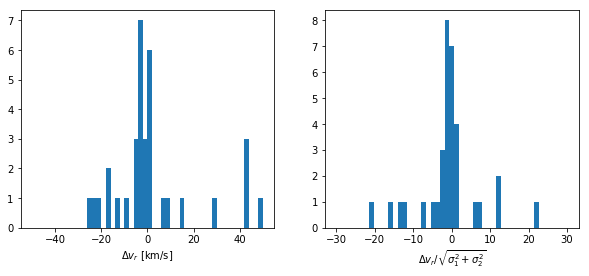

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(drv[~np.isnan(drv)], np.linspace(-50,50,51))
ax[0].set_xlabel('$\Delta v_r$ [km/s]')
ax[1].hist(drv[~np.isnan(drv)]/edrv[~np.isnan(drv)], np.linspace(-30,30,50));
ax[1].set_xlabel('$\Delta v_r / \sqrt{\sigma_1^2 + \sigma_2^2}$')

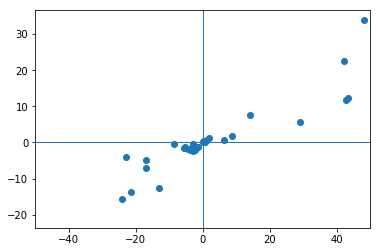

In [227]:
plt.scatter(drv[~np.isnan(drv)], drv[~np.isnan(drv)]/edrv[~np.isnan(drv)])
plt.xlim(-50,50)
plt.axhline(0,lw=1)
plt.axvline(0,lw=1)

In [16]:
pairdf['star1'] = rows[:,0]
pairdf['star2'] = rows[:,3]
pairdf['abs_drv'] = np.fabs(drv)
pairdf['abs_drv_edrv'] = np.fabs(drv/edrv)

In [17]:
pairdf['separation'] = [pair.separation[pair.group_id == g].values[0] for g in pairdf.index]
pairdf['angsep'] = [pair.angsep[pair.group_id == g].values[0] for g in pairdf.index]

In [18]:
pairdf.sort_values('abs_drv_edrv')

,group_id,star1,star2,abs_drv,abs_drv_edrv,separation,angsep
1817,2,2784.0,2785.0,0.04,0.010363,3.473,0.666
813,2,784.0,785.0,0.03,0.015643,1.371,0.482
3862,2,7809.0,7810.0,0.66,0.182468,1.083,20.605
2906,2,5125.0,5126.0,0.39,0.278935,4.152,4.905
1253,2,1634.0,2368.0,2.97,0.349916,4.146,103.099
2866,2,5038.0,5039.0,0.48,0.367862,4.788,0.442
3992,2,8257.0,8452.0,8.53,0.542431,5.936,105.773
3753,2,7437.0,7514.0,6.47,0.626846,9.409,171.261
336,2,23.0,135.0,1.33,0.803072,3.067,0.654
2600,2,4491.0,4492.0,1.90,1.124260,1.035,0.831


In [19]:
targets = pairdf.loc[pairdf.abs_drv_edrv<2].sort_values('abs_drv_edrv').copy()

In [20]:
print(len(targets), "pairs")

19 pairs


Try finding TIC ID with CTL match.

In [21]:
target_stars = pd.DataFrame({
        'row_id':targets[['star1', 'star2']].values.ravel(),
        'group_id':np.repeat(targets.index,2)
    })

target_stars = pd.merge(target_stars, candi, left_on='row_id', right_on='row_id', how='left')

In [26]:
target_stars.columns

Index(['group_id_x', 'row_id', 'tgas_source_id', 'name', 'ra', 'dec',
       'parallax', 'distance', 'G', 'J',
       ...
       'd', 'e_d', 'ebv', 'e_ebv', 'numcont', 'contratio', 'disposition',
       'duplicate_i', 'priority', 'subPriority'],
      dtype='object', length=105)

In [46]:
target_stars[['row_id','group_id_x', 'MatchID','ra','dec','pmRA', 'pmDEC', 'Tmag']].to_csv("target_star_MatchID.csv", index=False)

In [31]:
star.loc[target_stars.row_id, ['rave_obs_id']]

,rave_obs_id
2784.0,20031003_2024m65_134
2785.0,20060731_2056m66_035
784.0,20060819_2237m64_070
785.0,20110707_2237m64a_066
7809.0,20080725_2105m46_128
7810.0,20070911_2105m46_127
5125.0,20060816_0127m27_125
5126.0,20080902_0127m27_125
1634.0,20030617_1543m18_139
2368.0,20030618_1543m18_120


In [32]:
raveon = Table.read("/Users/semyeong/data/RAVE-on-v1.0.fits")

In [33]:
raveon[:3]

RAVE_OBS_ID,RAVEID,RA,DEC,HRV,eHRV,StdDev_HRV,MAD_HRV,CorrelationCoeff,PeakHeight,PeakWidth,CorrectionRV,SkyRV,eSkyRV,SkyCorrelationCoeff,Vrot_SPARV,ZeroPointFLAG,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,TEFF,LOGG,FE_H,O_H,MG_H,AL_H,SI_H,CA_H,NI_H,E_TEFF,E_LOGG,E_FE_H,E_O_H,E_MG_H,E_AL_H,E_SI_H,E_CA_H,E_NI_H,SNR,R_CHI_SQ,QC
str31,str16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool
20030412_0932m08_001,J093025.1-103336,142.604708333,-10.5600555556,30.596,3.905,0.895722923429,0.6746,16.66,0.824,69.6,2.276,4.62,2.683,9.06,nan,AAC,n,n,e,e,n,e,e,n,e,n,n,n,n,e,e,n,n,n,n,e,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,31.4046148209,2.78063770837,True
20030412_0932m08_003,J093210.0-103944,143.041791667,-10.6623055556,-5.789,4.579,1.64591607724,1.32604,12.73,0.751,67.182,2.321,1.14,1.876,12.85,nan,AAC,n,n,n,n,n,n,n,n,b,n,n,n,n,n,n,n,n,n,n,n,6844.03199568,4.08880414523,-0.0666253987334,nan,nan,nan,nan,nan,nan,92.6281881872,0.135620571209,0.0651060313422,nan,nan,nan,nan,nan,nan,30.2926594315,2.61218140943,False
20030412_0932m08_004,J093006.6-111703,142.5275,-11.2840555556,19.54,5.747,1.3083275329,0.9844,10.33,0.772,69.857,2.342,1.689,2.243,11.14,nan,AAC,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,34.8868799185,3.38829374137,False


In [41]:
# find index into RAVEON
ridx = []
for rid in star.loc[target_stars.row_id, ['rave_obs_id']].values:
    ridx.append(np.where(raveon['RAVE_OBS_ID'] == rid)[0][0])

In [44]:
raveon[ridx].write("target_star_raveon.csv")

In [48]:
!wc -l target_star*.csv

      39 target_star_MatchID.csv
      39 target_star_raveon.csv
      78 total


In [49]:
!head target_star*.csv

==> target_star_MatchID.csv <==
row_id,group_id_x,MatchID,ra,dec,pmRA,pmDEC,Tmag
2784.0,1817,372040411.0,309.780795,-66.452055,7.41988,-37.499,9.884
2785.0,1817,372040412.0,309.753919,-66.454874,7.33692,-38.2239,10.725
784.0,813,412052353.0,337.435162,-62.73761700000001,45.3432,-23.5715,10.716
785.0,813,412052352.0,337.452241,-62.739431999999994,45.2808,-23.6084,9.968
7809.0,3862,79303009.0,319.109547,-47.935676,114.991,-53.8314,9.757
7810.0,3862,126947802.0,318.70345299999997,-47.726832,115.04700000000001,-54.5788,10.206
5125.0,2906,55855777.0,23.0567,-27.561246,-36.2151,-80.0002,10.186
5126.0,2906,55856742.0,23.148796,-27.557221999999996,-34.4797,-80.1115,9.943
1634.0,1253,71114935.0,237.181388,-20.20774,-58.101000000000006,-10.2573,10.009

==> target_star_raveon.csv <==
RAVE_OBS_ID,RAVEID,RA,DEC,HRV,eHRV,StdDev_HRV,MAD_HRV,CorrelationCoeff,PeakHeight,PeakWidth,CorrectionRV,SkyRV,eSkyRV,SkyCorrelationCoeff,Vrot_SPARV,ZeroPointFLAG,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c1